In [1]:
import numpy as np
import sys
import json
import time
import datetime

#NN Surrogate model class
from injector_surrogate_quads import *

from sampling_functions import get_ground_truth, get_beamsize
#from emittance_calc import *
sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization


## Load inj model

In [2]:
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
Model.load_scaling()
Model.take_log_out = False

In [3]:
energy = 0.135

In [4]:
#Sim reference point to optimize around
from ref_config import ref_point
ref_point_import = ref_point
#convert to machine units
ref_point1 = Model.sim_to_machine(np.asarray(ref_point))

## Small example

In [12]:
# #this has to match beam_io.py fn....
# def get_sizes(quad, p1=0.4657, p2=-0.007063, p3=-0.01989):
#     return get_beamsize(Model, ref_point, p1, p2, p3, quad)

# # needs ref point in sim units
# init_range =  [-4, -3, -1,0] 

# global p1
# global p2
# global p3

# p1 = 0.4657
# p2 = -0.007063
# p3 = -0.01989
    
# x_sizes = np.array([get_sizes(x)[0] for x in init_range])
# y_sizes = np.array([get_sizes(x)[1] for x in init_range])

# get_normemit(0.135, init_range, init_range, x_sizes, y_sizes, adapt_ranges=True, num_points=5, show_plots=True)

# test w/ diff scan

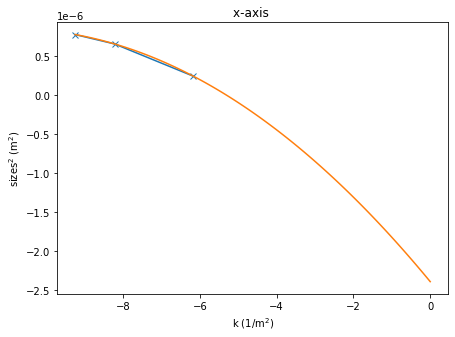

x axis: min. of poly fit is negative. Setting it to 0. Beamsize possibly too small.
Adjusting inverted poly.


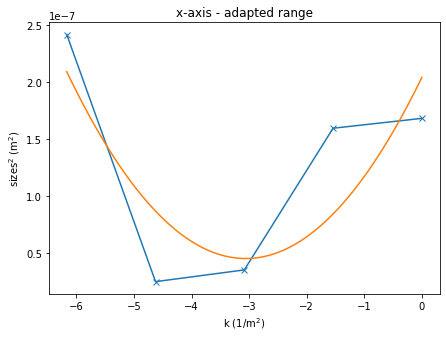

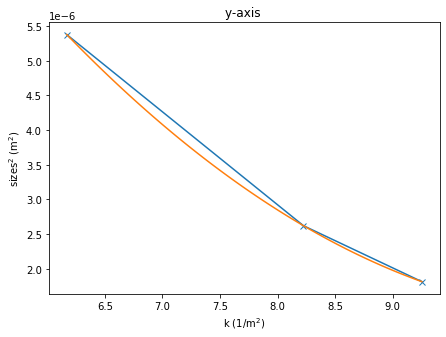

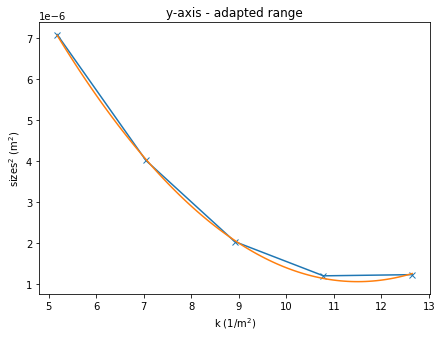

nemitx: 13.31, nemity: 190.83
bmagx: 4.83, bmagy: 2.79


In [11]:
def get_sizes(quad):
    return get_beamsize(Model, ref_point, 0.5657 , -0.01063 ,-0.01  , quad)

global p1
global p2
global p3

p1 = 0.5657
p2 = -0.01063
p3 = -0.01 
    
init_range =  [-4.5, -4, -3] 

x_sizes = np.array([get_sizes(x)[0] for x in init_range])
y_sizes = np.array([get_sizes(x)[1] for x in init_range])

get_normemit(0.135, init_range, init_range, x_sizes, y_sizes, adapt_ranges=True, num_points=5, show_plots=True);

x axis: min. of poly fit is negative. Setting it to 0.
Adjusting concave poly.


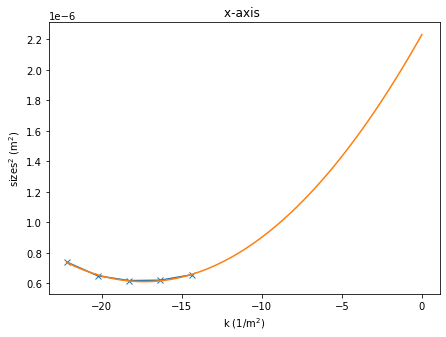

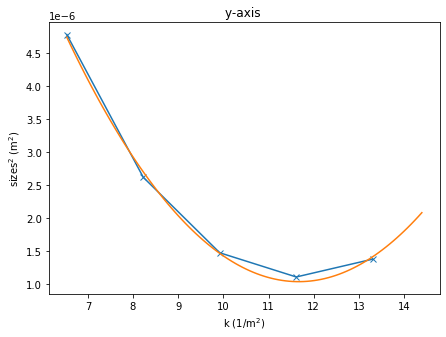

nemitx: 27.39, nemity: 182.64
bmagx: 3.77, bmagy: 2.78


In [6]:
def get_sizes(quad):
    return get_beamsize(Model, ref_point, 0.5657 , -0.01063 ,-0.01  , quad)

global p1
global p2
global p3

p1 = 0.5657
p2 = -0.01063
p3 = -0.01 
    
init_range =  [-7, -5,-4.5] 

x_sizes = np.array([get_sizes(x)[0] for x in init_range])
y_sizes = np.array([get_sizes(x)[1] for x in init_range])

get_normemit(0.135, init_range, init_range, x_sizes, y_sizes, adapt_ranges=True, num_points=5, show_plots=True);

# Running adapt ranges independetly


In [9]:
adapt_range(init_range, x_sizes, axis='x', num_points=5, save_plot=False, show_plots=True)

x axis: min. of poly fit is negative. Setting it to 0.
Adjusting concave poly.
[-14.3937931  -16.34534483 -18.29689655 -20.24844828 -22.2       ]


array([ -7.        ,  -7.94908006,  -8.89816013,  -9.84724019,
       -10.79632025])

# Testing BO

In [16]:
ref_point = ref_point1[0]

#input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','SQ01:b1_gradient','CQ01:b1_gradient','QE04:b1_gradient']

#output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']


    
def evaluate(varx,vary,varz,varscan=[-9, -5, -2, -1]): 
    print("\n")
    numscan = len(varscan)
    
    global p1
    global p2
    global p3
    
    p1 = varx
    p2 = vary
    p3 = varz
    
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((numscan,len(Model.model_in_list)))
    
    #fill in reference point around which to optimize
    for i in range(0,len(ref_point)):
        x_in[:,i]=ref_point[i] 

    #set solenoid, SQ, CQ to values from optimization step
    x_in[:, Model.loc_in[opt_var_names[0]]] = varx # 3
    x_in[:, Model.loc_in[opt_var_names[1]]] = vary # 5
    x_in[:, Model.loc_in[opt_var_names[2]]] = varz # 4
    
    #set quad 525 to values for scan
    x_in[:, Model.loc_in[opt_var_names[3]]] = varscan

    #output predictions
    y_out = Model.pred_machine_units(x_in) 
    
    emitx = y_out[:,Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    emity = y_out[:,Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    
    print(f"Scalar pred. emit: {np.sqrt(np.mean(emitx)/1e-6 * np.mean(emity)/1e-6):.3f}")
    #return -np.sqrt(np.mean(emitx)/1e-6 * np.mean(emity)/1e-6)
    
    x_rms = np.array(y_out[:,0])
    y_rms = np.array(y_out[:,1])
    norm_emit = get_normemit(0.135, varscan, varscan, x_rms, y_rms, adapt_ranges=True, num_points=5, show_plots=True);

    if np.isnan(norm_emit[0]) or np.isnan(norm_emit[1]):
        return -1000
    
    norm_emit = np.sqrt(norm_emit[0]*norm_emit[1])
    return  -norm_emit/1e-6

In [ ]:
# ref vals: 4.77969346e-01,  -6.87298943e-04, -1.49922712e-03
# bounds on input params 
pbounds = {'varx': (0.44, 0.5),
           'vary': (-0.02, 0.02),
           'varz': (-0.02, 0.02)     
          }

optimizer = BayesianOptimization(
    f = evaluate,
    pbounds = pbounds,
    random_state = 1,
)

optimizer.maximize(
    init_points=5,
    n_iter=10,
)

Scalar pred. emit: 0.658
nemitx: 0.95, nemity: 1.03
bmagx: 3.19, bmagy: 1.62
|  45       | -0.9901   |  0.4764   |  0.01382  | -0.01477  |

Scalar pred. emit: 0.594
y axis: min. of poly fit is negative. Setting it to 0. Beamsize possibly too small.
nemitx: 1.46, nemity: 1.17
bmagx: 2.33, bmagy: 1.13
|  50       | -1.306    |  0.4806   |  0.006527 | -0.003611 |

Scalar pred. emit: 0.647
y axis: min. of poly fit is negative. Setting it to 0. Beamsize possibly too small.
nemitx: 1.18, nemity: 1.20
bmagx: 2.28, bmagy: 1.33
|  22       | -1.189    |  0.4788   |  0.005076 | -0.01261  |

In [ ]:
evaluate( 0.4649 ,-0.02 , -0.01996 ,varscan=[-9, -5, -2, -1])

In [8]:
import numpy.polynomial.polynomial as poly
import datetime
import numpy as np 
import warnings

# for running on the machine
# from beam_io import get_updated_beamsizes
# get_sizes = get_updated_beamsizes

# constants for Q525 ONLY 
# TODO: clean up LCLS/machine specific info
m_0 = 0.511*1e-3 # mass in [GeV]
d = 2.26 # [m] distance between Q525 and OTR2
l = 0.108 # effective length [m]

def get_gradient(b_field, l_eff=0.108):
    """Returns the quad field gradient [T/m] 
        l_eff: effective length [m] 
        b_field: integrated field [kG]"""
    return np.array(b_field)*0.1 /l_eff
    
def get_k1(g, p):
    """Returns quad strength [1/m^2]
       g: quad field gradient [T/m]
       p: momentum [GeV] (or alternatively beta*E [GeV])"""
    return 0.2998 * g / p

def fit_sigma(sizes, k, axis, d=d, l=l, adapt_ranges=False, num_points=5, show_plots=False):
    """Fit sizes^2 = c0 + c1*k + c2*k^2
       returns: c0, c1, c2"""
    coefs = poly.polyfit(k, sizes**2, 2)
    
    if axis == 'x':
        min_k, max_k = np.min(k), 0
    elif axis == 'y':
        min_k, max_k = np.min(k), np.max(k)
    
    xfit = np.linspace(min_k, max_k, 100)

    #plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
    
    if adapt_ranges:
        try:
            coefs = adapt_range(k, sizes, axis=axis, fit_coefs=coefs, x_fit=xfit, num_points=num_points,\
                                save_plot=True, show_plots=show_plots)
            # log data
            timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
            if axis=="x":
                save_data(timestamp,0,0,0,0,sizes,0,k,0,str(adapt_ranges))
            if axis=="y":
                save_data(timestamp,0,0,0,0,0,sizes,0,k,str(adapt_ranges))
#         except NameError:
#             print("Error: A function to get beamsizes is not defined. Returning original fit.")
#             plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
#         except ValueError:
#             print("Error: Cannot adapt quad ranges. Returning original fit.")
#             plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        except ConcaveFitError:
            print("Error: Cannot adapt quad ranges due to concave poly. Returning original fit.")
            plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)     
    else:
        plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        
    # return c0,c1,c2
    c0, c1, c2 = coefs
    
    # matrix elements at quad 525
    sig_11 = c2 / (d*l)**2
    sig_12 = (-c1 - 2*d*l*sig_11) / (2*d**2*l)
    sig_22 = (c0 - sig_11 - 2*d*sig_12) / d**2
    
    return sig_11, sig_12, sig_22

def get_emit(sig11, sig12, sig22):
    """Returns emittance (not normalized)"""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            emit  = np.sqrt(sig11*sig22 - sig12**2)
            return emit
    except RuntimeWarning:
        return np.nan 
    
def get_bmag(sig11, sig12, sig22, emit, axis):
    """Calculates Bmag from calculated emittance
    and from initial Twiss at OTR2: HARDCODED from Matlab GUI"""
    # HARDCODED INIT TWISS PARAMS
    # TODO: clean up LCLS/machine specific info
    twiss0 = [1e-6, 1e-6, 1.113081026, 1.113021659, -6.89403587e-2, -7.029489754e-2]
    
    beta0 =  twiss0[2] if axis == 'x' else twiss0[3] if axis == 'y' else 0
    alpha0 = twiss0[4] if axis == 'x' else twiss0[5] if axis == 'y' else 0
    gamma0 = (1+alpha0**2)/beta0

    beta = sig11/emit
    alpha = -sig12/emit
    gamma = sig22/emit
    
    bmag = 0.5 * (beta*gamma0 - 2*alpha*alpha0 + gamma*beta0)
    return bmag

def get_normemit(energy, xrange, yrange, xrms, yrms, adapt_ranges=False, num_points=5, show_plots=False):
    """Returns normalized emittance [m]
       given quad values and beamsizes"""    
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)

    kx =  get_k1(get_gradient(xrange), beta*energy)
    ky = -get_k1(get_gradient(yrange), beta*energy)
    
    sig_11, sig_12, sig_22 = fit_sigma(np.array(xrms), kx, axis='x',\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    emitx = get_emit(sig_11, sig_12, sig_22)
    bmagx = get_bmag(sig_11, sig_12, sig_22, emitx, axis='x')

    sig_11, sig_12, sig_22 = fit_sigma(np.array(yrms), ky, axis='y',\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    emity = get_emit(sig_11, sig_12, sig_22)
    bmagy = get_bmag(sig_11, sig_12, sig_22, emity, axis='y')
    
    # log data
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    save_data(timestamp,emitx*gamma*beta,emity*gamma*beta,bmagx,bmagy,xrms,yrms,kx,ky,str(adapt_ranges))
        
    if np.isnan(emitx) or np.isnan(emity):
        return np.nan, np.nan, np.nan, np.nan
    
    print(f"nemitx: {emitx*gamma*beta/1e-6:.2f}, nemity: {emity*gamma*beta/1e-6:.2f}")
    print(f"bmagx: {bmagx:.2f}, bmagy: {bmagy:.2f}")

    return emitx*gamma*beta, emity*gamma*beta, bmagx, bmagy

def plot_fit(x, y, fit_coefs, x_fit, axis, save_plot=True, show_plots=False, title_suffix=""):
    """Plot and save the emittance fits of size**2 vs k"""
    import matplotlib.pyplot as plt
    import datetime
    fig = plt.figure(figsize=(7,5))
    ffit = np.poly1d(fit_coefs)
    plt.plot(x, y**2, marker="x")
    plt.plot(x_fit, poly.polyval(x_fit, fit_coefs))
    
    plt.xlabel(r"k (1/m$^2$)")
    plt.ylabel(r"sizes$^2$ (m$^2$)")
    plt.title(f"{axis}-axis "+title_suffix)
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    
    if save_plot:
        try:
            plt.savefig(f"./plots/emittance_{axis}_fit_{timestamp}.png", dpi=100)
        except:
            plt.savefig(f"./emittance_fit_{axis}_{timestamp}.png", dpi=100)
    if show_plots:
        plt.show()
    plt.close()
        
def get_quad_field(k, energy=0.135, l=0.108): 
    """Get quad field [kG] from k1 [1/m^2]"""
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)
    return np.array(k)*l/0.1/0.2998*energy*beta


def adapt_range(x, y, axis, fit_coefs=None, x_fit=None, energy=0.135, num_points=5, save_plot=False, show_plots=True):
    """Adjust scanning range for a given axis to fit around minimum"""
    """Returns new scan quad values if called without initial fit coefs"""
    """Returns new coefs if called from fit_sigma with initial fit coefs"""
    if fit_coefs is None:
        return_range = True
        
        gamma = energy/m_0
        beta = np.sqrt(1-1/gamma**2)
        k = get_k1(get_gradient(x), beta*energy)        

        if axis == 'x':
            min_k, max_k = np.min(k), 0
        elif axis == 'y':
            k=-k
            min_k, max_k = np.min(k), np.max(k)
        
        fit_coefs = poly.polyfit(k, y**2, 2)
        x_fit = np.linspace(min_k, max_k, 100)
        x=k
    else:
        return_range = False 
        
    if axis == 'x':
        min_x, max_x = np.min(x), 0
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = -22.2, 0
    elif axis == 'y':
        min_x, max_x = np.min(x), np.max(x)
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = 0, 22.2
        
    c0, c1, c2 = fit_coefs
    
    if c2<0:
        concave_function = True
    else:
        concave_function = False
    
    # find range within 2-3x the focus size 
    y_lim = np.min(poly.polyval(x_fit, fit_coefs))*4 
    if y_lim<0:
        print(f"{axis} axis: min. of poly fit is negative. Setting it to 0.")
        y_lim = 0
    roots = poly.polyroots((c0-y_lim, c1, c2))
    # Flag bad fit with complex roots
    if np.iscomplex(roots).any():
        print("Cannot adapt quad ranges, complex root encountered.")
        raise ValueError("")
    
    # if roots are outside quad scanning range, set to scan range lim
    if roots[0]<min_x_range:
        roots[0] = min_x_range
    if roots[1]>max_x_range:
        roots[1] = max_x_range
        
    # have at least 3 scanning points within roots
    range_fit = np.max(roots)-np.min(roots)
    if range_fit<2:
        # need at least 3 points for polynomial fit
        x_fine_fit = np.linspace(np.min(roots)-1.5, np.max(roots)+1.5, num_points)
        
    if concave_function:
        print("Adjusting concave poly.")
        # go to lower side of concave polynomials 
        # (assuming it is closer to the local minimum)
        x_min_concave = x[np.argmin(y)]
        #find the direction of sampling to minimum
        if (x[np.argmin(y)] - x[np.argmin(y)-2])<0:
            x_max_concave = min_x_range
        else:
            x_max_concave = max_x_range
        if (x_max_concave-x_min_concave)>8:
            # if range is too big (>8 1/m^2), narrow it down on the larger side
            x_min_concave = x_min_concave - 4        
        x_fine_fit = np.linspace(x_min_concave, x_max_concave, num_points)
        
    elif (np.max(roots)-np.min(roots))>8:
        # need to concentrate around min!
        dist_min = np.abs(x[np.argmin(y)]-np.min(roots))
        dist_max = np.abs(x[np.argmin(y)]-np.max(roots))
        if dist_min<dist_max:
            x_fine_fit = np.linspace(np.min(roots), np.max(roots)-4, num_points)
        elif dist_min>dist_max:
            x_fine_fit = np.linspace(np.min(roots)+4, np.max(roots), num_points)
        else:
            x_fine_fit = np.linspace(np.min(roots)+2, np.max(roots)-2, num_points)
            
    else:
        x_fine_fit = np.linspace(roots[0], roots[1], num_points)

    if return_range:
        # if this function is called without initial scan
        # return the new quad measurement range for this axis (in kG!!)
        print(x_fine_fit)
        return np.array([get_quad_field(ele) for ele in x_fine_fit])
        
    # GET NEW BEAMSIZES 
    # this takes B in kG not K
    if axis=="x":
        # for sim ONLY:
        # ref point needs to be in sim units with this function
        fine_fit_sizes = np.array([get_beamsize(Model, ref_point_import, p1, p2, p3, \
                                                get_quad_field(ele))[0] for ele in x_fine_fit])
        # for machine:
#         fine_fit_sizes = np.array([get_updated_beamsizes(get_quad_field(ele))[0] for ele in x_fine_fit])

    elif axis == "y":
        fine_fit_sizes = np.array([get_beamsize(Model, ref_point_import, p1, p2, p3, \
                                                -get_quad_field(ele))[1] for ele in x_fine_fit])
#         fine_fit_sizes = np.array([get_updated_beamsizes(-get_quad_field(ele))[1] for ele in x_fine_fit])
    
    # fit
    coefs = poly.polyfit(x_fine_fit, fine_fit_sizes**2, 2)
    xfit = np.linspace(np.min([min_x,np.min(x_fine_fit)]),np.max([max_x,np.max(x_fine_fit)]), 100)
    plot_fit(x_fine_fit, fine_fit_sizes, coefs, xfit, axis=axis, save_plot=save_plot, show_plots=show_plots)

    return coefs

def save_data(timestamp, nex, ney, bmx, bmy, xsizes, ysizes, kx, ky, adapted):
    f= open(f"emit_calc_log.csv", "a+")
    f.write(f"{timestamp},{nex},{ney},{bmx},{bmy},{xsizes},{ysizes},{kx},{ky},{adapted}\n")
    f.close()
    
class ConcaveFitError(Exception):
    """Raised when the adapted range emit 
    fit results in concave polynomial"""
    pass

In [10]:
import numpy.polynomial.polynomial as poly
import datetime
import numpy as np 
import warnings

# try:
#     from beam_io import get_updated_beamsizes

m_0 = 0.511*1e-3 # mass in [GeV]
d = 2.26 # [m] distance between Q525 and OTR2
l = 0.108 # effective length [m]

def get_gradient(b_field, l_eff=0.108):
    """Returns the quad field gradient [T/m] 
        l_eff: effective length [m] 
        b_field: integrated field [kG]"""
    return np.array(b_field)*0.1 /l_eff
    
def get_k1(g, p):
    """Returns quad strength [1/m^2]
       g: quad field gradient [T/m]
       p: momentum [GeV] (or alternatively beta*E [GeV])"""
    return 0.2998 * g / p

def fit_sigma(sizes, k, axis, d=d, l=l, adapt_ranges=False, num_points=5, show_plots=False):
    """Fit sizes^2 = c0 + c1*k + c2*k^2
       returns: c0, c1, c2"""
    coefs = poly.polyfit(k, sizes**2, 2)
    
    if axis == 'x':
        min_k, max_k = np.min(k), 0
    elif axis == 'y':
        min_k, max_k = np.min(k), np.max(k)
    
    xfit = np.linspace(min_k, max_k, 100)

    plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)

    if adapt_ranges:
        try:
            coefs = adapt_range(k, sizes, coefs, xfit, axis=axis, num_points=num_points,\
                                save_plot=True, show_plots=show_plots)
            # log data
            timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
            if axis=="x":
                save_data(timestamp,0,0,0,0,sizes,0,k,0,str(adapt_ranges))
            if axis=="y":
                save_data(timestamp,0,0,0,0,0,sizes,0,k,str(adapt_ranges))
#         except NameError:
#             print("Error: A function to get beamsizes is not defined. Returning original fit.")
#             plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        except ValueError:
            print("Error: Cannot adapt quad ranges. Returning original fit.")
            plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        except InvertedFitError:
            print("Error: Cannot adapt quad ranges due to inverted poly. Returning original fit.")
            plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
    else:
        plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        
    # return c0,c1,c2
    c0, c1, c2 = coefs
    
    # matrix elements at quad 525
    sig_11 = c2 / (d*l)**2
    sig_12 = (-c1 - 2*d*l*sig_11) / (2*d**2*l)
    sig_22 = (c0 - sig_11 - 2*d*sig_12) / d**2
    
    return sig_11, sig_12, sig_22

def get_emit(sig11, sig12, sig22):
    """Returns emittance (not normalized)"""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            emit  = np.sqrt(sig11*sig22 - sig12**2)
            return emit
    except RuntimeWarning:
        return np.nan 
    
def get_bmag(sig11, sig12, sig22, emit, axis):
    """Calculates Bmag from calculated emittance
    and from initial Twiss at OTR2: HARDCODED from Matlab GUI"""
    # HARDCODED INIT TWISS PARAMS
    twiss0 = [1e-6, 1e-6, 1.113081026, 1.113021659, -6.89403587e-2, -7.029489754e-2]
    
    beta0 =  twiss0[2] if axis == 'x' else twiss0[3] if axis == 'y' else 0
    alpha0 = twiss0[4] if axis == 'x' else twiss0[5] if axis == 'y' else 0
    gamma0 = (1+alpha0**2)/beta0

    beta = sig11/emit
    alpha = -sig12/emit
    gamma = sig22/emit
    
    bmag = 0.5 * (beta*gamma0 - 2*alpha*alpha0 + gamma*beta0)
    return bmag

def get_normemit(energy, xrange, yrange, xrms, yrms, adapt_ranges=False, num_points=5, show_plots=False):
    """Returns normalized emittance [m]
       given quad values and beamsizes"""    
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)

    kx = get_k1(get_gradient(xrange), beta*energy)
    ky = get_k1(get_gradient(yrange), beta*energy)
    
    sig_11, sig_12, sig_22 = fit_sigma(np.array(xrms), kx, axis='x',\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    emitx = get_emit(sig_11, sig_12, sig_22)
    bmagx = get_bmag(sig_11, sig_12, sig_22, emitx, axis='x')

    sig_11, sig_12, sig_22 = fit_sigma(np.array(yrms), -ky, axis='y',\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    emity = get_emit(sig_11, sig_12, sig_22)
    bmagy = get_bmag(sig_11, sig_12, sig_22, emity, axis='y')
    
    # log data
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    save_data(timestamp,emitx*gamma*beta,emity*gamma*beta,bmagx,bmagy,xrms,yrms,kx,ky,str(adapt_ranges))
        
    if np.isnan(emitx) or np.isnan(emity):
        return np.nan, np.nan, np.nan, np.nan
    
    print(f"nemitx: {emitx*gamma*beta/1e-6:.2f}, nemity: {emity*gamma*beta/1e-6:.2f}")
    print(f"bmagx: {bmagx:.2f}, bmagy: {bmagy:.2f}")

    return emitx*gamma*beta, emity*gamma*beta, bmagx, bmagy

def plot_fit(x, y, fit_coefs, x_fit, axis, save_plot=True, show_plots=False, title_suffix=""):
    """Plot and save the emittance fits of size**2 vs k"""
    import matplotlib.pyplot as plt
    import datetime
    fig = plt.figure(figsize=(7,5))
    ffit = np.poly1d(fit_coefs)
    plt.plot(x, y**2, marker="x")
    plt.plot(x_fit, poly.polyval(x_fit, fit_coefs))
    
    plt.xlabel(r"k (1/m$^2$)")
    plt.ylabel(r"sizes$^2$ (m$^2$)")
    plt.title(f"{axis}-axis "+title_suffix)
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    
    if save_plot:
        try:
            plt.savefig(f"./plots/emittance_{axis}_fit_{timestamp}.png", dpi=100)
        except:
            plt.savefig(f"./emittance_fit_{axis}_{timestamp}.png", dpi=100)
    if show_plots:
        plt.show()
    plt.close()
        
def get_quad_field(k, energy=0.135, l=0.108): 
    """Get quad field [kG] from k1 [1/m^2]"""
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)
    return np.array(k)*l/0.1/0.2998*energy*beta


def adapt_range(x, y, fit_coefs, x_fit, axis, num_points, save_plot=False, show_plots=True):
    """Adjust scanning range for a given axis to fit around minimum"""
    if axis == 'x':
        min_x, max_x = np.min(x), 0
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = -22.2, 0
    elif axis == 'y':
        min_x, max_x = np.min(x), np.max(x)
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = 0, 22.2
        
    c0, c1, c2 = fit_coefs
    
    if c2<0:
        inverted_function = True
    else:
        inverted_function = False
    
    # find range within 2-3x the focus size 
    y_lim = np.min(poly.polyval(x_fit, fit_coefs))*4 
    if y_lim<0:
        print(f"{axis} axis: min. of poly fit is negative. Setting it to 0. Beamsize possibly too small.")
        y_lim = 0
    roots = poly.polyroots((c0-y_lim, c1, c2))
    # Flag bad fit with complex roots
    if np.iscomplex(roots).any():
        print("Bad emittance fit, complex root encountered.")
        raise ValueError("Cannot adapt quad ranges.")
    
    # if roots are outside quad scanning range, set to scan range lim
    if roots[0]<min_x_range:
        roots[0] = min_x_range
    if roots[1]>max_x_range:
        roots[1] = max_x_range
        
    # have at least 3 scanning points within roots
    range_fit = np.max(roots)-np.min(roots)
    if range_fit<2:
        # need at least 3 points for polynomial fit
        x_fine_fit = np.linspace(np.min(roots)-1.5, np.max(roots)+1.5, num_points)
        
    if inverted_function:
        print("Adjusting inverted poly.")
        # go to minimum side of inverted polynomials
        x_min_inverted = x[np.argmin(y)]
        
        if (x[np.argmin(y)] - x[np.argmin(y)-2])<0:
            x_max_inverted = min_x_range
        else:
            x_max_inverted = max_x_range
        
        if (x_max_inverted-x_min_inverted)>8:
            x_min_inverted = x_min_inverted - 4
        x_fine_fit = np.linspace(x_min_inverted, x_max_inverted, num_points)
        
    elif (np.max(roots)-np.min(roots))>8:
        # need to concentrate around min!
        dist_min = np.abs(x[np.argmin(y)]-np.min(roots))
        dist_max = np.abs(x[np.argmin(y)]-np.max(roots))
        if dist_min<dist_max:
            x_fine_fit = np.linspace(np.min(roots), np.max(roots)-4, num_points)
        elif dist_min>dist_max:
            x_fine_fit = np.linspace(np.min(roots)+4, np.max(roots), num_points)
        else:
            x_fine_fit = np.linspace(np.min(roots)-2, np.max(roots)-2, num_points)
    else:
        x_fine_fit = np.linspace(roots[0], roots[1], num_points)

        
    # GET NEW BEAMSIZES 
    # this takes B in kG not K
    if axis=="x":
        # for sim ONLY:
        # ref point needs to be in sim units with this function
        fine_fit_sizes = np.array([get_beamsize(Model, ref_point_import, p1, p2, p3, \
                                                get_quad_field(ele))[0] for ele in x_fine_fit])
        # for machine:
#         fine_fit_sizes = np.array([get_updated_beamsizes(get_quad_field(ele))[0] for ele in x_fine_fit])

    elif axis == "y":
        fine_fit_sizes = np.array([get_beamsize(Model, ref_point_import, p1, p2, p3, \
                                                -get_quad_field(ele))[1] for ele in x_fine_fit])
#         fine_fit_sizes = np.array([get_updated_beamsizes(-get_quad_field(ele))[1] for ele in x_fine_fit])
    
    # fit
    coefs = poly.polyfit(x_fine_fit, fine_fit_sizes**2, 2)
    
    if coefs[2]<0:
        # raise error and skip adapted range fit
        raise InvertedFitError
        
    xfit = np.linspace(np.min(x_fine_fit),np.max(x_fine_fit), 100)
    plot_fit(x_fine_fit, fine_fit_sizes, coefs, xfit, axis=axis, \
                 save_plot=save_plot, show_plots=show_plots, title_suffix ="- adapted range")
    
    return coefs

def save_data(timestamp, nex, ney, bmx, bmy, xsizes, ysizes, kx, ky, adapted):
    f= open(f"emit_calc_log.csv", "a+")
    f.write(f"{timestamp},{nex},{ney},{bmx},{bmy},{xsizes},{ysizes},{kx},{ky},{adapted}\n")
    f.close()
    
class InvertedFitError(Exception):
    """Raised when the adapted range emit 
    fit results in inverted polynomial"""
    pass